## Telemedicina - Adesão e impacto

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [3]:
# 1. CARREGAMENTO E LIMPEZA
# ---------------------------------------------------------
file_path = 'TMEDTREND_PUBLIC_250827.csv'
df = pd.read_csv(file_path)

In [4]:
# Filtrar para remover agregações nacionais e anuais para focar na variação granular
# Mantemos apenas dados de níveis estaduais e trimestrais específicos
df_clean = df[
    (df['Bene_Geo_Desc'] != 'National') & 
    (df['quarter'] != 'Overall') &
    (df['Pct_Telehealth'].notna()) # Remove linhas sem a variável alvo
].copy()

In [5]:
# Converter colunas numéricas que podem ter sido lidas como texto
cols_to_numeric = ['Total_Bene_TH_Elig', 'Total_PartB_Enrl', 'Total_Bene_Telehealth', 'Pct_Telehealth']
for col in cols_to_numeric:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
df_clean.dropna(subset=['Pct_Telehealth'], inplace=True)

In [6]:
# 2. DEFINIÇÃO DO ALVO (TARGET)
# ---------------------------------------------------------
# Definir o limiar de "Alta Adoção" (Top 25%)
threshold = df_clean['Pct_Telehealth'].quantile(0.75)
df_clean['High_Adoption'] = (df_clean['Pct_Telehealth'] > threshold).astype(int)

In [7]:
print(f"Limiar de Alta Adoção (> 75%): {threshold:.4f}")
print(f"Distribuição das Classes:\n{df_clean['High_Adoption'].value_counts(normalize=True)}")

Limiar de Alta Adoção (> 75%): 0.2302
Distribuição das Classes:
High_Adoption
0    0.750111
1    0.249889
Name: proportion, dtype: float64


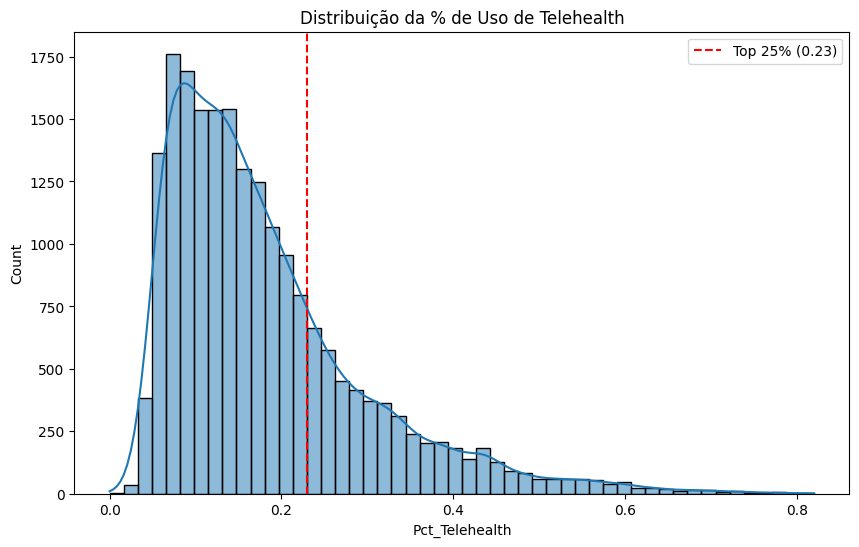

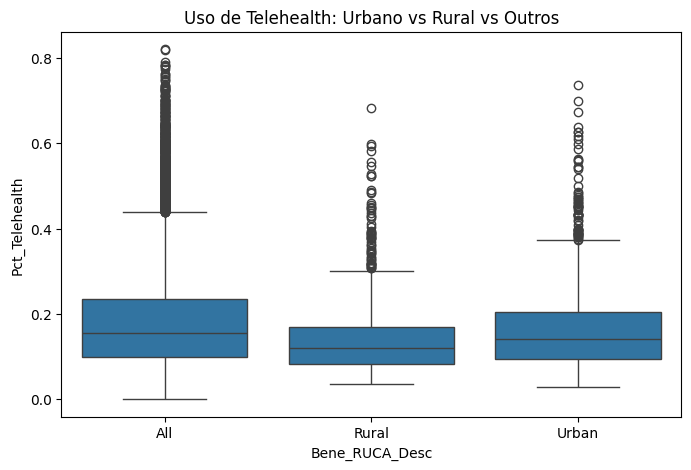

In [8]:
# 3. ANÁLISE EXPLORATÓRIA (EDA)
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Pct_Telehealth'], bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label=f'Top 25% ({threshold:.2f})')
plt.title('Distribuição da % de Uso de Telehealth')
plt.legend()
plt.show()

# Boxplot para ver impacto Rural vs Urbano
plt.figure(figsize=(8, 5))
sns.boxplot(x='Bene_RUCA_Desc', y='Pct_Telehealth', data=df_clean)
plt.title('Uso de Telehealth: Urbano vs Rural vs Outros')
plt.show()

In [9]:
# 4. PREPARAÇÃO PARA MACHINE LEARNING
# ---------------------------------------------------------
# Selecionar features relevantes (Categoricas e Numéricas)
features_cat = ['Bene_Geo_Desc', 'Bene_Mdcd_Mdcr_Enrl_Stus', 'Bene_Race_Desc', 
                'Bene_Sex_Desc', 'Bene_Age_Desc', 'Bene_RUCA_Desc']
# Nota: Removemos 'Year' e 'quarter' para focar em características demográficas, 
# mas poderiam ser incluídos se o objetivo fosse previsão temporal.

# Codificação de Variáveis Categóricas (One-Hot Encoding)
X = pd.get_dummies(df_clean[features_cat], drop_first=True)
y = df_clean['High_Adoption']

# Divisão Treino/Teste (70% Treino, 30% Teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


--- Relatório de Classificação ---
              precision    recall  f1-score   support

           0       0.81      0.95      0.88      4552
           1       0.72      0.35      0.47      1545

    accuracy                           0.80      6097
   macro avg       0.77      0.65      0.67      6097
weighted avg       0.79      0.80      0.77      6097


--- Matriz de Confusão ---


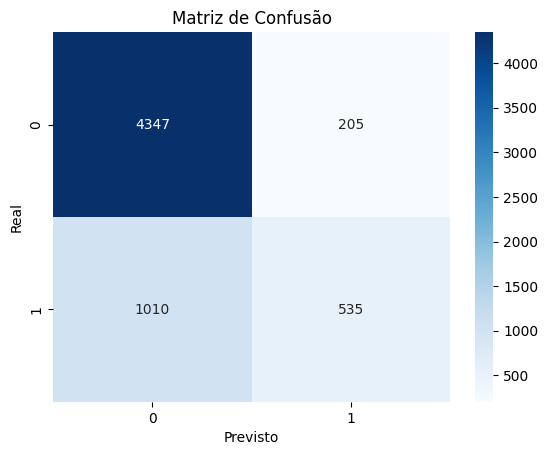

In [10]:
# 5. TREINAMENTO DO MODELO
# ---------------------------------------------------------
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Previsões
y_pred = clf.predict(X_test)

# 6. AVALIAÇÃO DE DESEMPENHO
# ---------------------------------------------------------
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred))

print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

In [11]:
# 7. IMPORTÂNCIA DAS VARIÁVEIS (Quais fatores mais influenciam?)
# ---------------------------------------------------------
feature_importances = pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print("\n--- Top 10 Fatores Mais Importantes ---")
print(feature_importances.head(10))


--- Top 10 Fatores Mais Importantes ---
                                              importance
Bene_Geo_Desc_California                        0.142712
Bene_Age_Desc_All                               0.059182
Bene_Geo_Desc_Hawaii                            0.048143
Bene_Age_Desc_85 and over                       0.045302
Bene_Geo_Desc_Massachusetts                     0.041794
Bene_Age_Desc_75-84                             0.039814
Bene_Age_Desc_65-74                             0.037323
Bene_Mdcd_Mdcr_Enrl_Stus_Medicare & Medicaid    0.035667
Bene_Race_Desc_American Indian/Alaska Native    0.021417
Bene_Geo_Desc_District Of Columbia              0.019647
